In [4]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pystan

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [122]:
import pymc3 as pm
import theano
import theano.tensor as T
from scipy.stats.stats import pearsonr

In [5]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [6]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [7]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,bmi,ethnicity,insurance,...,ea_tv_pulm_htn,ea_tv_tr,ea_lv_cavity,ea_lv_diastolic,ea_lv_systolic,ea_lv_wall,ea_rv_cavity,ea_rv_diastolic_fluid,ea_rv_systolic,ea_rv_wall
0,200001,152234,55973,22290 days 19:06:12,F,170.18,27.669135,9.553853,ASIAN - ASIAN INDIAN,Medicare,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200003,163557,27513,17625 days 19:50:04,M,NaN,78.224998,NaN,WHITE,Private,...,1.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN,0.0,NaN
2,200006,189514,10950,19736 days 11:28:14,M,NaN,82.400002,NaN,OTHER,Medicaid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200007,129310,20707,15818 days 10:03:37,M,177.80,126.000000,39.857223,WHITE,Private,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200009,129607,29904,17353 days 10:34:32,F,160.02,85.833331,33.520264,WHITE,Private,...,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN


In [8]:
len(ef)

61532

In [9]:
## apply filters
F = (ef['filter_vaso'] | ef['filter_angus_sepsis']) \
        & ~ef['filter_hard_cardiogenic'] \
        & ~ef['filter_chronic_dialysis'] \
        & ef['filter_adult'] \
        & (ef.st_micu | ef.st_sicu | ef.st_nsicu)

In [10]:
ef = ef.loc[F]
len(ef)

13443

## Calculate MDRD and add to features table

In [11]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [12]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    3793
1    2997
2    2061
3    1820
4    1725
5     657
dtype: int64

In [13]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    6790
1    3881
2    2382
dtype: int64

## Create general features table

In [16]:
def normalize(x):
    x = x.copy()
    I = ~np.isnan(x)
    x[I] = (x[I] - x[I].mean())/x[I].std()
    return x

In [82]:
## is apache score everr missing?
sum(np.isnan(ef.apsiii))

0

In [117]:
X = pd.DataFrame()

# build the features table
age = ef.age/np.timedelta64('1', 'Y') # time in years
age_masked = age < 0 # if age is less than 0, then the person is above 89 (90?)
age = normalize(age)
age[age_masked] = 0
X['age'] = age
X['age_over_90'] = age_masked.astype(float)

gender = ef.gender
gender = (gender == 'F').astype(float)
X['gender'] = gender

bmi = ef.bmi
bmi_missing = np.isnan(bmi)
bmi = normalize(bmi)
bmi[bmi_missing] = 0
X['bmi'] = bmi
X['bmi_missing'] = bmi_missing.astype(float)

mech_vent = ef.vf_first_day_vent.astype(float)
X['mech_vent'] = mech_vent

chf = ef.ex_congestive_heart_failure.astype(float)
X['CHF'] = chf

mdrd = ef.mdrd
mdrd_missing = np.isnan(mdrd)
mdrd = normalize(mdrd)
mdrd[mdrd_missing] = 0
X['mdrd'] = mdrd

# MDRD missing is already largely covered by BMI missing
# the only other missing values come from missing creatinine lab
# so add that
creatinine_missing = np.isnan(ef.lab_creatinine)
X['creatinine_missing'] = creatinine_missing.astype(float)

apsiii = ef.apsiii
#apsiii_missing = np.isnan(apsiii)
apsiii = normalize(apsiii)
#apsiii[apsiii_missing] = 0
X['apsiii'] = apsiii
#X['apsiii_missing'] = apsiii_missing.astype(float)

lvsys = ef.ea_lv_systolic
lv_missing = np.isnan(lvsys).astype(float)
lv_normal = (lvsys == 0).astype(float)
lv_hyperdynamic = (lvsys == -1).astype(float)
lv_mild_depressed = (lvsys == 1).astype(float)
lv_mod_depressed = (lvsys == 2).astype(float)
lv_sev_depressed = (lvsys == 3).astype(float)
X['lv_missing'] = lv_missing
X['lv_normal'] = lv_normal
X['lv_hyper'] = lv_hyperdynamic
X['lv_mild'] = lv_mild_depressed
X['lv_moderate'] = lv_mod_depressed
X['lv_severe'] = lv_sev_depressed

lactate = ef.lab_lactate
lactate_missing = np.isnan(lactate)
lactate = normalize(lactate)
lactate[lactate_missing] = 0
X['lactate'] = lactate
X['lactate_missing'] = lactate_missing.astype(float)

X.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe,lactate,lactate_missing
1,0.086189,0.0,0.0,0.000000,1.0,1.0,0.0,0.401448,0.0,-0.180877,0.0,0.0,0.0,0.0,1.0,0.0,0.766996,0.0
16,0.451056,0.0,1.0,0.000000,1.0,1.0,1.0,0.000000,1.0,0.400357,1.0,0.0,0.0,0.0,0.0,0.0,3.945737,0.0
20,0.153221,0.0,0.0,0.003012,0.0,0.0,0.0,0.369755,0.0,0.176806,0.0,1.0,0.0,0.0,0.0,0.0,0.090782,0.0
22,0.300244,0.0,0.0,-0.050124,0.0,0.0,0.0,0.692746,0.0,-1.030372,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0
23,0.151474,0.0,1.0,0.000000,1.0,1.0,0.0,0.815494,0.0,-0.493849,1.0,0.0,0.0,0.0,0.0,0.0,0.591287,0.0


## Some helper model building functions

In [153]:
def ridge(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    # observation error
    sigma = pm.HalfCauchy('sigma', 5)
    
    yh = T.dot(X, beta) + intercept
    ydist = pm.Normal('y', mu=yh, sd=sigma, observed=y)

In [178]:
def logistic(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    yh = T.nnet.sigmoid(T.dot(X, beta) + intercept)
    ydist = pm.Bernoulli('y', yh, observed=y)

## Simple linear model for predicting fluid balance on day 1

In [118]:
## predictive model of fluids given
y_fluid = ef.fb_day1_balance_ml
missing = np.isnan(y_fluid)
np.sum(missing)

1011

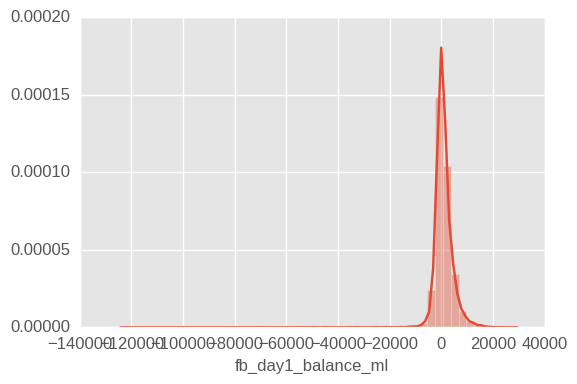

In [146]:
sns.distplot(ef.fb_day1_balance_ml[~missing])

In [149]:
# truncate at -8, +8 by changing people out of that range to NaN, cause wow
missing |= (ef.fb_day1_balance_ml < -8000) | (ef.fb_day1_balance_ml > 8000)
sum(missing)

1500

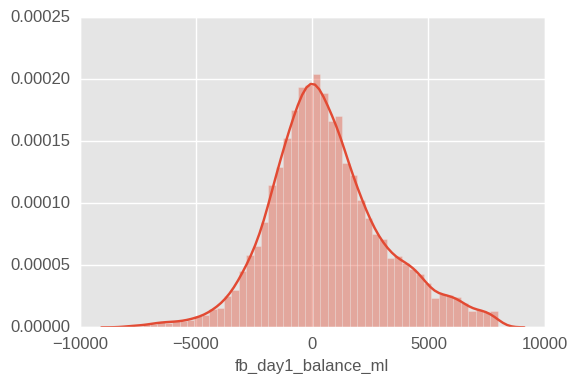

In [150]:
sns.distplot(ef.fb_day1_balance_ml[~missing])

In [151]:
X_fluid = X.loc[~missing]
y_fluid = normalize(y_fluid[~missing])
len(y_fluid)

11943

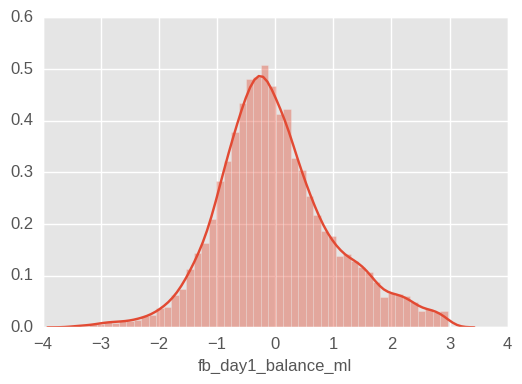

In [152]:
sns.distplot(y_fluid)

In [154]:
with pm.Model() as model:
    #pm.glm.glm('y ~ x', data)
    ridge(X_fluid, y_fluid)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step)

         Current function value: 15984.057176
         Iterations: 42
         Function evaluations: 156
         Gradient evaluations: 144


100%|██████████| 2000/2000 [00:54<00:00, 36.95it/s]


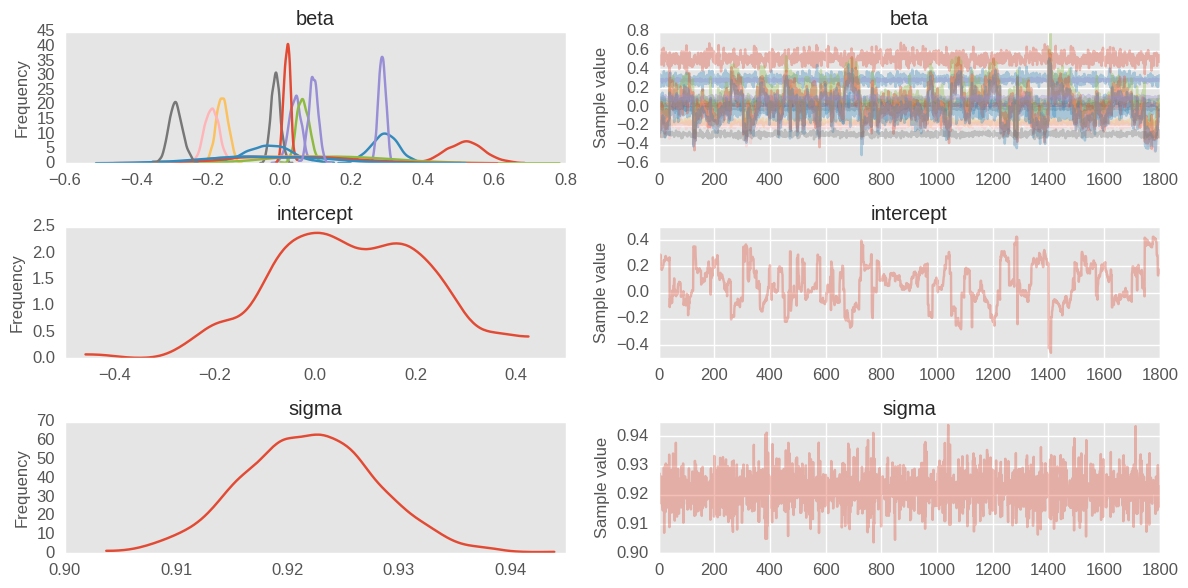

In [155]:
_ = pm.traceplot(trace[200:])

In [156]:
sample_coefs = pd.DataFrame(trace[200:]['beta'], columns=X_fluid.columns)
sample_coefs['intercept'] = trace[200:]['intercept']
sample_coefs.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe,lactate,lactate_missing,intercept
0,0.511019,0.250460,0.033770,-0.033827,-0.156398,0.078090,-0.183922,0.019346,-0.087505,0.296465,-0.212197,-0.192091,0.062757,-0.170318,-0.122091,-0.261055,0.089894,-0.283806,0.255289
1,0.556342,0.315010,0.057133,-0.005553,-0.156369,0.051487,-0.185022,0.029608,0.015263,0.289852,-0.182196,-0.153671,-0.123414,-0.183684,-0.092192,-0.192001,0.112450,-0.314473,0.240754
2,0.556342,0.315010,0.057133,-0.005553,-0.156369,0.051487,-0.185022,0.029608,0.015263,0.289852,-0.182196,-0.153671,-0.123414,-0.183684,-0.092192,-0.192001,0.112450,-0.314473,0.240754
3,0.525605,0.287878,0.049932,-0.016395,-0.154180,0.066603,-0.154932,0.024920,0.013974,0.290499,-0.181335,-0.172524,-0.126711,-0.246355,-0.013915,-0.142121,0.097538,-0.318800,0.240805
4,0.482776,0.320902,0.033837,-0.005335,-0.149378,0.067082,-0.221017,0.022634,-0.110138,0.281347,-0.174512,-0.173944,0.013052,-0.071962,-0.322047,-0.207989,0.099895,-0.272389,0.255367


In [157]:
sample_coefs.describe()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe,lactate,lactate_missing,intercept
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.518060,0.293995,0.043162,-0.010587,-0.160195,0.065692,-0.189065,0.021312,-0.029031,0.286265,-0.007541,0.011123,0.137058,-0.010918,0.027984,-0.038927,0.094966,-0.289946,0.069320
std,0.053128,0.038905,0.017255,0.012624,0.016962,0.017438,0.020130,0.009324,0.061844,0.010336,0.152014,0.152385,0.159940,0.160094,0.167175,0.162008,0.012995,0.019002,0.151543
min,0.349655,0.164403,-0.021945,-0.053508,-0.211254,0.002500,-0.250451,-0.008787,-0.214889,0.250261,-0.354290,-0.344670,-0.325778,-0.475903,-0.461652,-0.512519,0.054070,-0.351960,-0.458456
25%,0.481447,0.267933,0.031685,-0.019517,-0.171768,0.053283,-0.203398,0.014785,-0.073881,0.279193,-0.121669,-0.102750,0.020358,-0.129162,-0.092201,-0.149322,0.086621,-0.303075,-0.037653
50%,0.519195,0.294491,0.043881,-0.010497,-0.160227,0.065066,-0.189017,0.021592,-0.029190,0.286353,-0.004538,0.008044,0.134104,-0.010243,0.024832,-0.045413,0.094842,-0.290317,0.062025
75%,0.553157,0.319806,0.054745,-0.002072,-0.148729,0.077943,-0.174819,0.027797,0.013401,0.293464,0.102874,0.119571,0.247119,0.101264,0.140453,0.078306,0.103731,-0.277686,0.184134
max,0.684524,0.448256,0.092186,0.035863,-0.105793,0.120734,-0.129365,0.050786,0.152021,0.318615,0.507258,0.531414,0.782154,0.549674,0.608276,0.519742,0.144604,-0.229209,0.425332


In [158]:
W = sample_coefs.values[:,:X_fluid.shape[1]]
b = sample_coefs['intercept'].values

y_ppc = np.dot(X_fluid.values, W.T) + b
y_ppc = y_ppc.T

In [159]:
r2_ppc = np.zeros(len(y_ppc))
for i in range(len(y_ppc)):
    yh = y_ppc[i]
    r = pearsonr(yh, y_fluid)[0]
    r2_ppc[i] = r**2

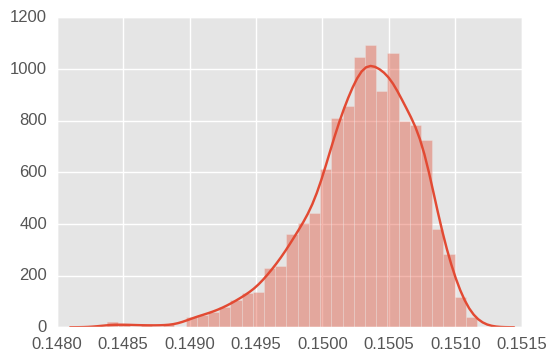

In [160]:
sns.distplot(r2_ppc)

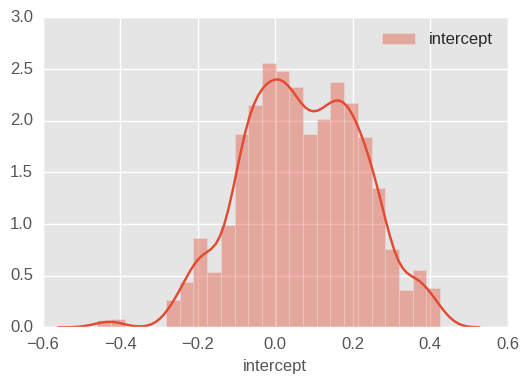

In [161]:
coefs = ['intercept']
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
_ = plt.legend(loc='best')

,age,age_over_90,gender,bmi,bmi_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.518060,0.293995,0.043162,-0.010587,-0.160195
std,0.053128,0.038905,0.017255,0.012624,0.016962
min,0.349655,0.164403,-0.021945,-0.053508,-0.211254
25%,0.481447,0.267933,0.031685,-0.019517,-0.171768
50%,0.519195,0.294491,0.043881,-0.010497,-0.160227
75%,0.553157,0.319806,0.054745,-0.002072,-0.148729
max,0.684524,0.448256,0.092186,0.035863,-0.105793


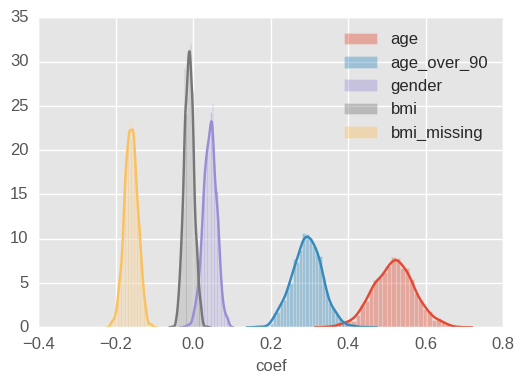

In [162]:
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,mech_vent,CHF,apsiii,mdrd,creatinine_missing,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.065692,-0.189065,0.286265,0.021312,-0.029031,0.094966,-0.289946
std,0.017438,0.020130,0.010336,0.009324,0.061844,0.012995,0.019002
min,0.002500,-0.250451,0.250261,-0.008787,-0.214889,0.054070,-0.351960
25%,0.053283,-0.203398,0.279193,0.014785,-0.073881,0.086621,-0.303075
50%,0.065066,-0.189017,0.286353,0.021592,-0.029190,0.094842,-0.290317
75%,0.077943,-0.174819,0.293464,0.027797,0.013401,0.103731,-0.277686
max,0.120734,-0.129365,0.318615,0.050786,0.152021,0.144604,-0.229209


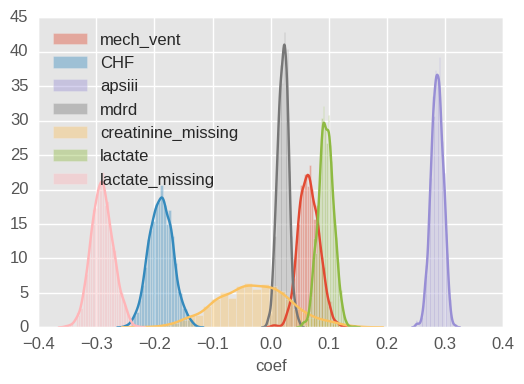

In [163]:
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.007541,0.011123,0.137058,-0.010918,0.027984,-0.038927
std,0.152014,0.152385,0.159940,0.160094,0.167175,0.162008
min,-0.354290,-0.344670,-0.325778,-0.475903,-0.461652,-0.512519
25%,-0.121669,-0.102750,0.020358,-0.129162,-0.092201,-0.149322
50%,-0.004538,0.008044,0.134104,-0.010243,0.024832,-0.045413
75%,0.102874,0.119571,0.247119,0.101264,0.140453,0.078306
max,0.507258,0.531414,0.782154,0.549674,0.608276,0.519742


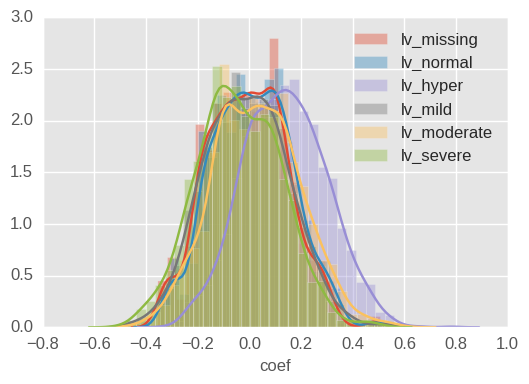

In [164]:
coefs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

## Simple linear model for predicting 30-day mortality

In [180]:
## make the features table. include fluid balance on days 1,2,3 of ICU stay
X_mortality = X.copy()

def bound(fl):
    return (fl < -8000) | (fl > 8000)

fluid_day1 = ef.fb_day1_balance_ml.values
fl_missing = np.isnan(fluid_day1) | bound(fluid_day1) # also filter insane fluid balances
fluid_day1[~fl_missing] = normalize(fluid_day1[~fl_missing])
fluid_day1[fl_missing] = 0
X_mortality['fluid_day1'] = fluid_day1
X_mortality['fluid_day1_missing'] = fl_missing.astype(float)

fluid_day2 = ef.fb_day2_balance_ml.values
fl_missing = np.isnan(fluid_day2) | bound(fluid_day2)
fluid_day2[~fl_missing] = normalize(fluid_day2[~fl_missing])
fluid_day2[fl_missing] = 0
X_mortality['fluid_day2'] = fluid_day2
X_mortality['fluid_day2_missing'] = fl_missing.astype(float)

fluid_day3 = ef.fb_day3_balance_ml.values
fl_missing = np.isnan(fluid_day3) | bound(fluid_day3)
fluid_day3[~fl_missing] = normalize(fluid_day3[~fl_missing])
fluid_day3[fl_missing] = 0
X_mortality['fluid_day3'] = fluid_day3
X_mortality['fluid_day3_missing'] = fl_missing.astype(float)

In [181]:
y_mortality = (ef.dod - ef.intime) < np.timedelta64(30, 'D')
y_mortality = y_mortality.astype(float)
y_mortality.mean(), y_mortality.sum(), len(y_mortality)

(0.26422673510377148, 3552.0, 13443)

In [182]:
with pm.Model() as model:
    #pm.glm.glm('y ~ x', data)
    logistic(X_mortality, y_mortality)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step)

Optimization terminated successfully.
         Current function value: 6570.382672
         Iterations: 33
         Function evaluations: 43
         Gradient evaluations: 43


100%|██████████| 2000/2000 [04:30<00:00,  7.40it/s]


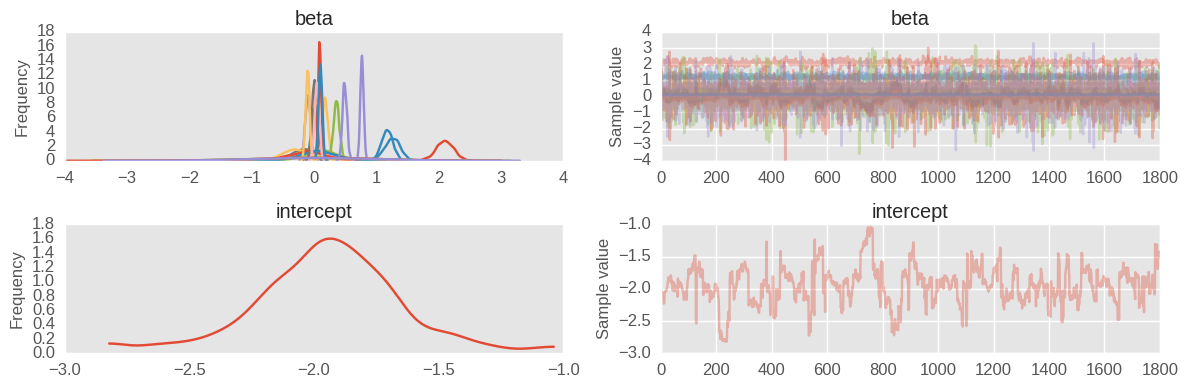

In [183]:
_ = pm.traceplot(trace[200:])

In [184]:
sample_coefs = pd.DataFrame(trace[200:]['beta'], columns=X_mortality.columns)
sample_coefs['intercept'] = trace[200:]['intercept']
sample_coefs.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,lv_severe,lactate,lactate_missing,fluid_day1,fluid_day1_missing,fluid_day2,fluid_day2_missing,fluid_day3,fluid_day3_missing,intercept
0,1.991041,1.091386,-0.106574,0.012822,0.156888,0.289490,0.069326,0.109886,0.960646,0.724114,...,0.379486,0.484404,0.015256,-0.104421,1.667380,0.029340,-1.006167,0.114691,1.830729,-2.156435
1,1.907724,1.147652,-0.131328,-0.036124,0.150450,0.366917,-0.030883,0.063433,1.459458,0.798367,...,0.319689,0.476477,-0.009258,-0.090154,-1.019334,-0.007722,1.755482,0.117689,-0.715883,-2.094433
2,1.907724,1.147652,-0.131328,-0.036124,0.150450,0.366917,-0.030883,0.063433,1.459458,0.798367,...,0.319689,0.476477,-0.009258,-0.090154,-1.019334,-0.007722,1.755482,0.117689,-0.715883,-2.094433
3,1.908551,1.098978,-0.112411,0.054390,0.148785,0.395049,-0.055790,0.054850,1.346011,0.753002,...,0.467590,0.524237,0.092801,-0.117839,1.471575,0.060716,-0.679058,0.113809,0.004145,-2.042062
4,1.912903,1.092121,-0.112247,0.085384,0.166839,0.359478,-0.008219,0.064040,1.162952,0.765498,...,0.401050,0.486658,0.013794,-0.137984,1.517184,0.061287,0.317306,0.079129,-1.332216,-2.058362


In [185]:
sample_coefs.describe()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,lv_severe,lactate,lactate_missing,fluid_day1,fluid_day1_missing,fluid_day2,fluid_day2_missing,fluid_day3,fluid_day3_missing,intercept
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,...,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.095919,1.172399,-0.098504,-0.003373,0.181766,0.358893,0.033022,0.089512,1.253417,0.768031,...,0.068414,0.492581,0.024070,-0.103159,-0.032732,0.045812,-0.000734,0.103212,0.006152,-1.944325
std,0.141125,0.090209,0.042907,0.037484,0.047087,0.047477,0.049130,0.023061,0.124067,0.026956,...,0.315212,0.036184,0.049477,0.031225,1.023116,0.036157,0.949582,0.029017,0.967143,0.291929
min,1.597046,0.891257,-0.235091,-0.170313,0.044336,0.193365,-0.136274,0.015529,0.862161,0.671680,...,-1.008821,0.365797,-0.127885,-0.208452,-3.563429,-0.083416,-3.965271,0.021235,-3.372523,-2.821553
25%,1.998262,1.111927,-0.127512,-0.026051,0.150435,0.327295,-0.001386,0.073820,1.173470,0.749839,...,-0.132126,0.468687,-0.010035,-0.123366,-0.723390,0.021942,-0.619057,0.083398,-0.638715,-2.118546
50%,2.096780,1.172577,-0.098158,-0.000464,0.179536,0.358456,0.033162,0.089286,1.255562,0.767733,...,0.062297,0.491717,0.023152,-0.102935,-0.038551,0.045845,0.007992,0.102646,-0.001078,-1.938192
75%,2.192565,1.233650,-0.070959,0.020208,0.211672,0.388451,0.066500,0.104849,1.338679,0.786100,...,0.263024,0.517411,0.057565,-0.082715,0.667017,0.069616,0.635384,0.122850,0.664606,-1.771412
max,2.530164,1.445993,0.063620,0.126396,0.353078,0.510147,0.188337,0.165523,1.707952,0.863375,...,1.154913,0.627412,0.212514,0.038849,3.154141,0.157708,3.004049,0.209484,3.298793,-1.038819


In [190]:
W = sample_coefs.values[:,:X_mortality.shape[1]]
b = sample_coefs['intercept'].values

y_ppc = np.dot(X_mortality.values, W.T) + b
y_ppc = y_ppc.T
y_ppc.shape, y_mortality.shape

((1800, 13443), (13443,))

In [197]:
acc_ppc = (y_ppc > 0).astype(float) == y_mortality.values
acc_ppc = acc_ppc.mean(axis=1)

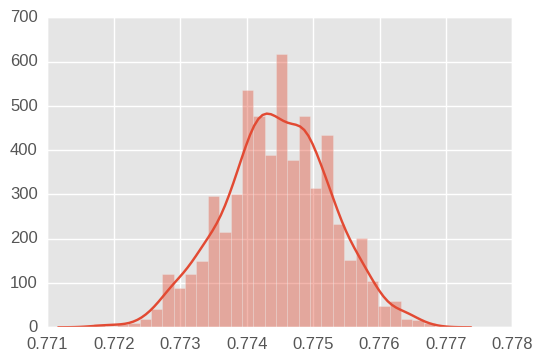

In [198]:
sns.distplot(acc_ppc)

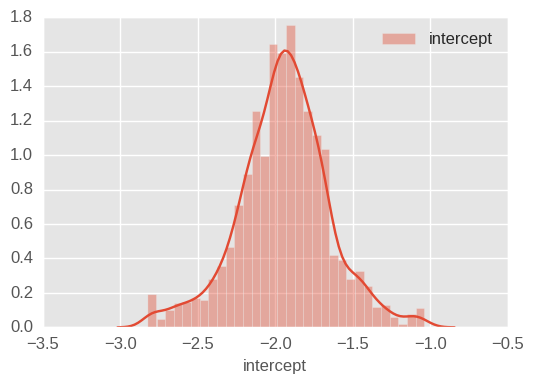

In [199]:
coefs = ['intercept']
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
_ = plt.legend(loc='best')

,age,age_over_90,gender,bmi,bmi_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.095919,1.172399,-0.098504,-0.003373,0.181766
std,0.141125,0.090209,0.042907,0.037484,0.047087
min,1.597046,0.891257,-0.235091,-0.170313,0.044336
25%,1.998262,1.111927,-0.127512,-0.026051,0.150435
50%,2.096780,1.172577,-0.098158,-0.000464,0.179536
75%,2.192565,1.233650,-0.070959,0.020208,0.211672
max,2.530164,1.445993,0.063620,0.126396,0.353078


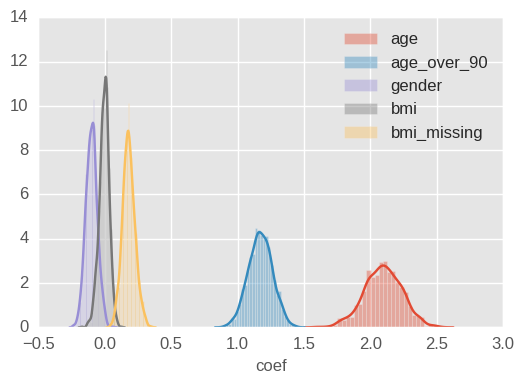

In [200]:
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,mech_vent,CHF,apsiii,mdrd,creatinine_missing,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.358893,0.033022,0.768031,0.089512,1.253417,0.492581,0.024070
std,0.047477,0.049130,0.026956,0.023061,0.124067,0.036184,0.049477
min,0.193365,-0.136274,0.671680,0.015529,0.862161,0.365797,-0.127885
25%,0.327295,-0.001386,0.749839,0.073820,1.173470,0.468687,-0.010035
50%,0.358456,0.033162,0.767733,0.089286,1.255562,0.491717,0.023152
75%,0.388451,0.066500,0.786100,0.104849,1.338679,0.517411,0.057565
max,0.510147,0.188337,0.863375,0.165523,1.707952,0.627412,0.212514


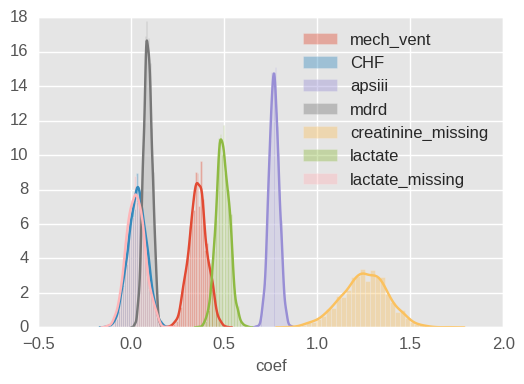

In [201]:
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.111150,-0.271172,0.133993,-0.034374,-0.094200,0.068414
std,0.285533,0.290854,0.302681,0.305771,0.323145,0.315212
min,-0.985134,-1.185658,-0.784152,-0.996843,-1.214867,-1.008821
25%,-0.281923,-0.446237,-0.052547,-0.227685,-0.298630,-0.132126
50%,-0.125250,-0.284572,0.120959,-0.043947,-0.090983,0.062297
75%,0.048746,-0.107524,0.304359,0.149209,0.086699,0.263024
max,0.782538,0.655898,1.095599,1.051761,0.982833,1.154913


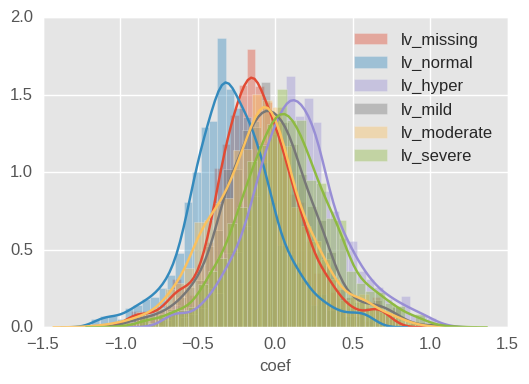

In [202]:
coefs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,fluid_day1,fluid_day2,fluid_day3
count,1800.000000,1800.000000,1800.000000
mean,-0.103159,0.045812,0.103212
std,0.031225,0.036157,0.029017
min,-0.208452,-0.083416,0.021235
25%,-0.123366,0.021942,0.083398
50%,-0.102935,0.045845,0.102646
75%,-0.082715,0.069616,0.122850
max,0.038849,0.157708,0.209484


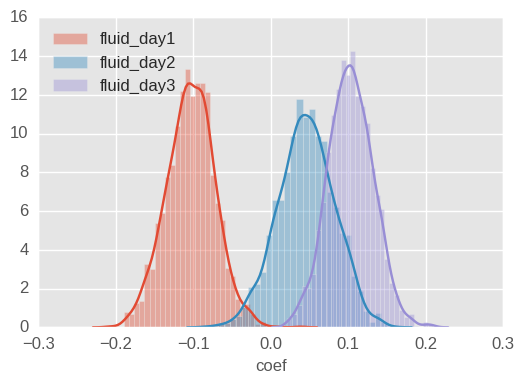

In [204]:
coefs = ['fluid_day1', 'fluid_day2', 'fluid_day3']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,fluid_day1_missing,fluid_day2_missing,fluid_day3_missing
count,1800.000000,1800.000000,1800.000000
mean,-0.032732,-0.000734,0.006152
std,1.023116,0.949582,0.967143
min,-3.563429,-3.965271,-3.372523
25%,-0.723390,-0.619057,-0.638715
50%,-0.038551,0.007992,-0.001078
75%,0.667017,0.635384,0.664606
max,3.154141,3.004049,3.298793


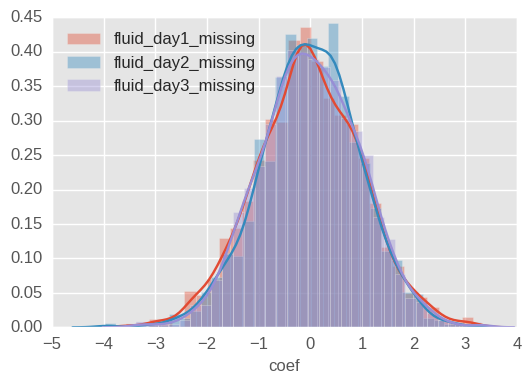

In [205]:
coefs = ['fluid_day1_missing', 'fluid_day2_missing', 'fluid_day3_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')